# An ML Investigation into AutoSklearn, CrabNet, and CrabNet with transfer learning regression and classification models applied to the ionics dataset

In [11]:
import os
import gc 

import pickle as pk

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch 
from torch.cuda import empty_cache

from tqdm import tqdm

from sklearn.model_selection import LeaveOneGroupOut, StratifiedKFold

from CrabNet.kingcrab import CrabNet
from CrabNet.model import Model
from CrabNet.get_compute_device import get_compute_device

from autosklearn.estimators import AutoSklearnRegressor, AutoSklearnClassifier

from sklearn.metrics import mean_absolute_error as mae, \
                            r2_score as r2, \
                            accuracy_score as acc, \
                            matthews_corrcoef as mcc

from ElMD import ElMD

from IPython.display import HTML, Javascript, display

# AutoSklearn is buggy, this restarts the entire kernel and runs all cells as workaround
def restart_kernel():
    display(HTML(
        '''
            <script>
                code_show = false;
                function restart_run_all(){
                    IPython.notebook.kernel.restart();
                    setTimeout(function(){
                        IPython.notebook.execute_all_cells();
                    }, 10000)
                }
                function code_toggle() {
                    if (code_show) {
                        $('div.input').hide(200);
                    } else {
                        $('div.input').show(200);
                    }
                    code_show = !code_show
                }
                restart_run_all();
            </script>
        '''
    ))

compute_device = get_compute_device()

In [2]:
# Load in the dataset 
df = pd.read_csv("data/ml_dataset.csv")
df

,ID,composition,source,temperature,target,log_target,family,ChemicalFamily,structure,pretty_formula,classification_target,loco,formula
0,2,Li2OHBr,10.1002/aenm.201700971,22.06,-6.267606,-6.267606,Anti-Perovskite,Oxides and Other Anions,0,Li0.4 O0.2 Br0.2 H0.2,0,3,Li0.4 O0.2 Br0.2 H0.2
1,3,Li2.4OH0.6Cl,10.1002/aenm.201700971,26.00,-7.050610,-7.050610,Anti-Perovskite,Oxides and Other Anions,0,Li0.48 O0.2 Cl0.2 H0.12,0,2,Li0.48 O0.2 Cl0.2 H0.12
2,4,Li2.1OH0.9Cl,10.1002/aenm.201700971,26.00,-7.094204,-7.094204,Anti-Perovskite,Oxides and Other Anions,0,Li0.42 O0.2 Cl0.2 H0.18,0,3,Li0.42 O0.2 Cl0.2 H0.18
3,5,Li2OHCl,10.1002/aenm.201700971,26.00,-7.148130,-7.148130,Anti-Perovskite,Oxides and Other Anions,0,Li0.4 O0.2 Cl0.2 H0.2,0,3,Li0.4 O0.2 Cl0.2 H0.2
4,6,Li2.7OH0.3Cl,10.1002/aenm.201700971,26.00,-8.136677,-8.136677,Anti-Perovskite,Oxides and Other Anions,0,Li0.54 O0.2 Cl0.2 H0.06,0,2,Li0.54 O0.2 Cl0.2 H0.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,2026,Li3.6Ge0.4P0.6S4,10.1149/1.1379028,25.00,-3.654909,-3.654909,Thio-LISICON,NaN,13,Li0.419 Ge0.047 P0.07 S0.465,1,3,Li0.419 Ge0.047 P0.07 S0.465
399,2027,Li3.35Ge0.35P0.65S4,10.1149/1.1379028,25.00,-2.737394,-2.737394,Thio-LISICON,NaN,13,Li0.401 Ge0.042 P0.078 S0.479,1,3,Li0.401 Ge0.042 P0.078 S0.479
400,2028,Li6NiCl8,10.1002/zaac.19875531020,25.00,-9.569675,-9.569675,Rocksalt,NaN,12,Li0.4 Ni0.067 Cl0.533,1,3,Li0.4 Ni0.067 Cl0.533
401,2029,Li6CoCl8,10.1002/zaac.19875531020,25.00,-5.821821,-5.821821,Rocksalt,NaN,12,Li0.4 Co0.067 Cl0.533,0,3,Li0.4 Co0.067 Cl0.533


# Define Hyperparameters and Generate all Data

In [4]:
n_runs = 5
batch_size = 2**9
n_epochs=250
autoskl_timeout=10 * 60

/mnt/c/Users/camer/Dropbox/University/ThirdYear/IonicConductors/LiIonML/CrabNet/utils.py:515: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['count'] = [len(_element_composition(form)) for form in df['formula']]
Generating EDM: 100%|██████████| 352/352 [00:00<00:00, 213044.01formulae/s]
/mnt/c/Users/camer/Dropbox/University/ThirdYear/IonicConductors/LiIonML/CrabNet/utils.py:515: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['count'] = [len(_element_composition(form)) for form in df['formula']]
Generati

LOCO_TransferCrabnet_Clf_run_0_fold_0

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu
Model size: 11987206 parameters

loading data with up to 6 elements in the formula
loading data with up to 6 elements in the formula
True
stepping every 10 training passes, cycling lr every 10 epochs
checkin at 20 epochs to match lr scheduler
Using BCE loss for classification task



/home/cameron/miniconda3/envs/ionics/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/cameron/miniconda3/envs/ionics/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/cameron/miniconda3/envs/ionics/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Epoch: 0/20 --- train MCC: 0.000 val MCC: 0.000


/home/cameron/miniconda3/envs/ionics/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/cameron/miniconda3/envs/ionics/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/cameron/miniconda3/envs/ionics/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/cameron/miniconda3/envs/ionics/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/cameron/miniconda3/envs/ionics/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered i

Epoch: 19/20 --- train MCC: 0.398 val MCC: 0.000


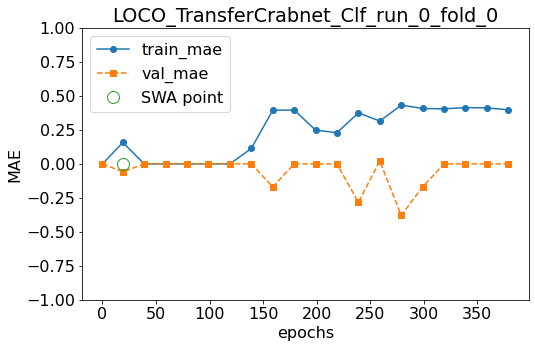

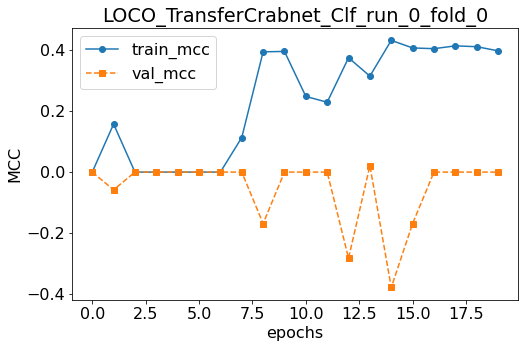

/mnt/c/Users/camer/Dropbox/University/ThirdYear/IonicConductors/LiIonML/CrabNet/utils.py:515: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['count'] = [len(_element_composition(form)) for form in df['formula']]
Generating EDM: 100%|██████████| 352/352 [00:00<00:00, 94356.43formulae/s]
/mnt/c/Users/camer/Dropbox/University/ThirdYear/IonicConductors/LiIonML/CrabNet/utils.py:515: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['count'] = [len(_element_composition(form)) for form in df['formula']]
Generatin


MCC: 0.021006132059823077
ACC: 0.5490196078431373
Exists
LOCO_CrabNet_Reg_run_0_fold_0
MCC: 0.021006132059823077
ACC: 0.5490196078431373
Exists
LOCO_TransferCrabnet_Reg_run_0_fold_0

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu
Model size: 11987206 parameters

loading data with up to 6 elements in the formula
loading data with up to 6 elements in the formula
False
stepping every 10 training passes, cycling lr every 10 epochs
checkin at 20 epochs to match lr scheduler


0
Epoch: 0/20 --- train mae: 1.82 val mae: 1.35
1
2
3
4
5
9
Epoch: 19/20 --- train mae: 1.67 val mae: 1.24


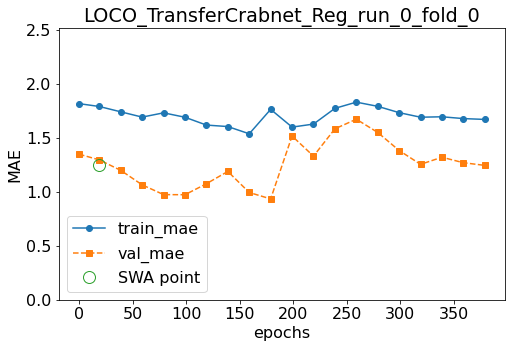

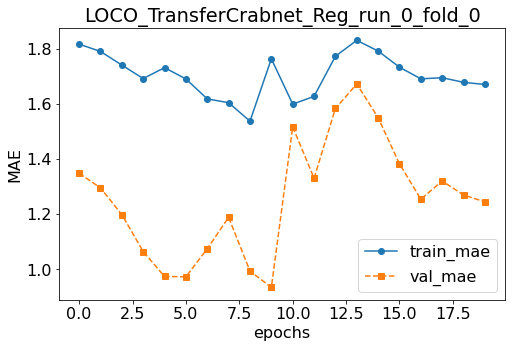


MAE: 0.9344476484784893
R2: 0.013136716002649318
LOCO_CrabNet_Clf_run_0_fold_0
MAE: 0.9344476484784893
R2: 0.013136716002649318
LOCO_TransferCrabnet_Clf_run_0_fold_1


/mnt/c/Users/camer/Dropbox/University/ThirdYear/IonicConductors/LiIonML/CrabNet/utils.py:515: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['count'] = [len(_element_composition(form)) for form in df['formula']]
Generating EDM: 100%|██████████| 356/356 [00:00<00:00, 140019.90formulae/s]
/mnt/c/Users/camer/Dropbox/University/ThirdYear/IonicConductors/LiIonML/CrabNet/utils.py:515: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['count'] = [len(_element_composition(form)) for form in df['formula']]
Generati


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu
Model size: 11987206 parameters

loading data with up to 6 elements in the formula
loading data with up to 6 elements in the formula
True
stepping every 10 training passes, cycling lr every 10 epochs
checkin at 20 epochs to match lr scheduler
Using BCE loss for classification task



/home/cameron/miniconda3/envs/ionics/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/cameron/miniconda3/envs/ionics/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/cameron/miniconda3/envs/ionics/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Epoch: 0/20 --- train MCC: 0.000 val MCC: 0.000


/home/cameron/miniconda3/envs/ionics/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/cameron/miniconda3/envs/ionics/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/cameron/miniconda3/envs/ionics/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/cameron/miniconda3/envs/ionics/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/cameron/miniconda3/envs/ionics/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered i

Epoch 19 failed to improve.
Discarded: 1/3 weight updates ♻🗑️
Epoch: 19/20 --- train MCC: 0.529 val MCC: -0.088


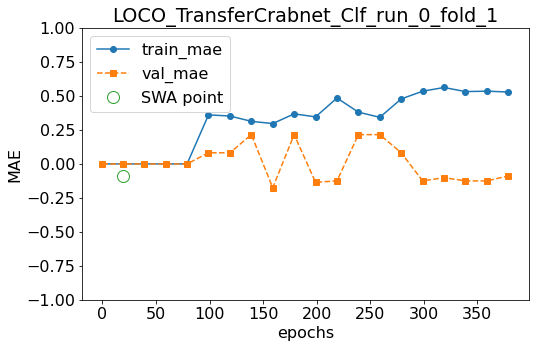

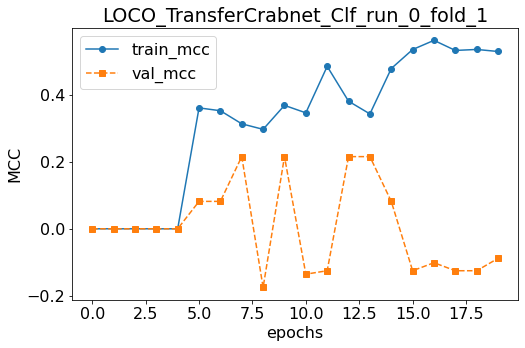

/mnt/c/Users/camer/Dropbox/University/ThirdYear/IonicConductors/LiIonML/CrabNet/utils.py:515: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['count'] = [len(_element_composition(form)) for form in df['formula']]
Generating EDM: 100%|██████████| 356/356 [00:00<00:00, 94961.35formulae/s]
/mnt/c/Users/camer/Dropbox/University/ThirdYear/IonicConductors/LiIonML/CrabNet/utils.py:515: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['count'] = [len(_element_composition(form)) for form in df['formula']]
Generatin


MCC: 0.2153527608232662
ACC: 0.7021276595744681
Exists
LOCO_CrabNet_Reg_run_0_fold_1
MCC: 0.2153527608232662
ACC: 0.7021276595744681
Exists
LOCO_TransferCrabnet_Reg_run_0_fold_1

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu
Model size: 11987206 parameters

loading data with up to 6 elements in the formula
loading data with up to 6 elements in the formula
False
stepping every 10 training passes, cycling lr every 10 epochs
checkin at 20 epochs to match lr scheduler


0
Epoch: 0/20 --- train mae: 1.6 val mae: 2.34
14
16
19
Epoch: 19/20 --- train mae: 1.25 val mae: 2.32


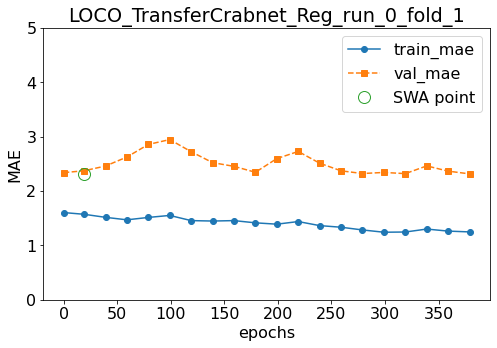

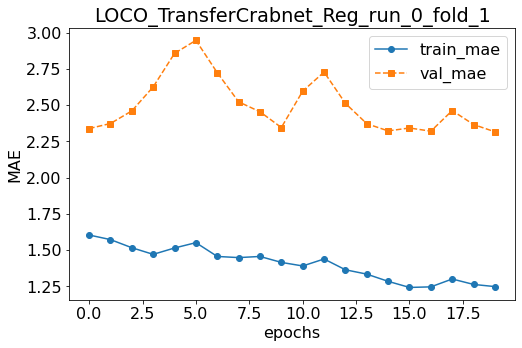

/mnt/c/Users/camer/Dropbox/University/ThirdYear/IonicConductors/LiIonML/CrabNet/utils.py:515: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['count'] = [len(_element_composition(form)) for form in df['formula']]
Generating EDM: 100%|██████████| 308/308 [00:00<00:00, 147470.96formulae/s]
/mnt/c/Users/camer/Dropbox/University/ThirdYear/IonicConductors/LiIonML/CrabNet/utils.py:515: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['count'] = [len(_element_composition(form)) for form in df['formula']]
Generati


MAE: 2.3168505455585238
R2: -0.4386011928438798
LOCO_CrabNet_Clf_run_0_fold_1
MAE: 2.3168505455585238
R2: -0.4386011928438798
LOCO_TransferCrabnet_Clf_run_0_fold_2

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu
Model size: 11987206 parameters

loading data with up to 6 elements in the formula
loading data with up to 6 elements in the formula
True
stepping every 10 training passes, cycling lr every 10 epochs
checkin at 20 epochs to match lr scheduler
Using BCE loss for classification task


Epoch: 0/20 --- train MCC: -0.110 val MCC: -0.135


/home/cameron/miniconda3/envs/ionics/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/cameron/miniconda3/envs/ionics/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/cameron/miniconda3/envs/ionics/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/cameron/miniconda3/envs/ionics/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/cameron/miniconda3/envs/ionics/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered i

Epoch: 19/20 --- train MCC: 0.525 val MCC: 0.020


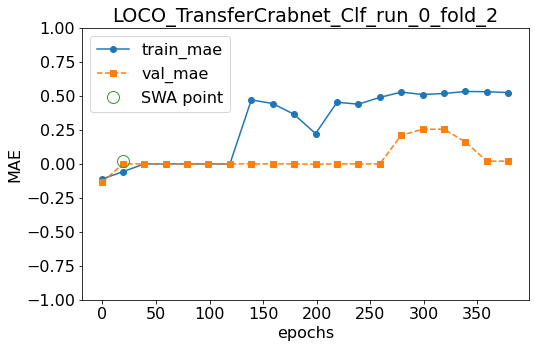

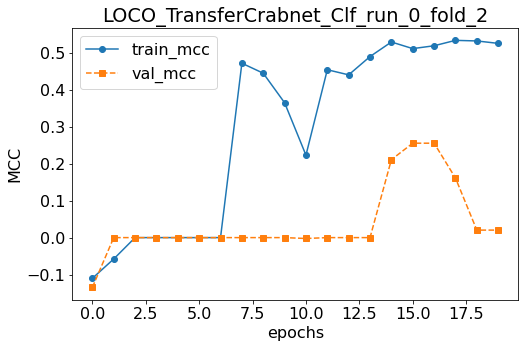

/mnt/c/Users/camer/Dropbox/University/ThirdYear/IonicConductors/LiIonML/CrabNet/utils.py:515: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['count'] = [len(_element_composition(form)) for form in df['formula']]
Generating EDM: 100%|██████████| 308/308 [00:00<00:00, 117333.84formulae/s]
/mnt/c/Users/camer/Dropbox/University/ThirdYear/IonicConductors/LiIonML/CrabNet/utils.py:515: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['count'] = [len(_element_composition(form)) for form in df['formula']]
Generati


MCC: 0.25503068522533534
ACC: 0.6421052631578947
Exists
LOCO_CrabNet_Reg_run_0_fold_2
MCC: 0.25503068522533534
ACC: 0.6421052631578947
Exists
LOCO_TransferCrabnet_Reg_run_0_fold_2

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu
Model size: 11987206 parameters

loading data with up to 6 elements in the formula
loading data with up to 6 elements in the formula
False
stepping every 10 training passes, cycling lr every 10 epochs
checkin at 20 epochs to match lr scheduler


0
Epoch: 0/20 --- train mae: 1.82 val mae: 1.3
1
2
3
4
5
8
14
16
Epoch: 19/20 --- train mae: 1.21 val mae: 1.11


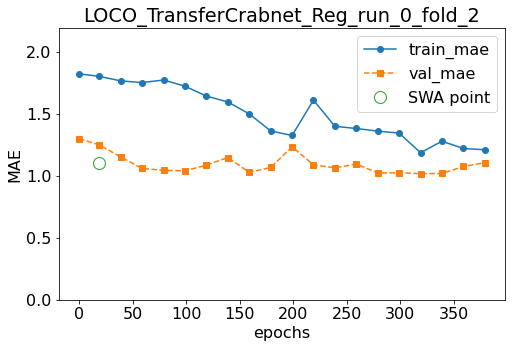

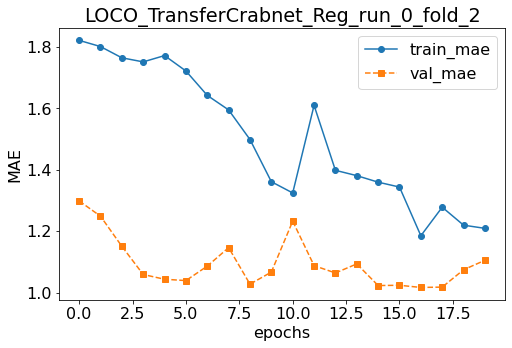

/mnt/c/Users/camer/Dropbox/University/ThirdYear/IonicConductors/LiIonML/CrabNet/utils.py:515: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['count'] = [len(_element_composition(form)) for form in df['formula']]
Generating EDM: 100%|██████████| 363/363 [00:00<00:00, 95366.89formulae/s]
/mnt/c/Users/camer/Dropbox/University/ThirdYear/IonicConductors/LiIonML/CrabNet/utils.py:515: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['count'] = [len(_element_composition(form)) for form in df['formula']]
Generatin


MAE: 1.016950303629825
R2: 0.06005703082483704
LOCO_CrabNet_Clf_run_0_fold_2
MAE: 1.016950303629825
R2: 0.06005703082483704
LOCO_TransferCrabnet_Clf_run_0_fold_3

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu
Model size: 11987206 parameters

loading data with up to 6 elements in the formula
loading data with up to 6 elements in the formula
True
stepping every 10 training passes, cycling lr every 10 epochs
checkin at 20 epochs to match lr scheduler
Using BCE loss for classification task



/home/cameron/miniconda3/envs/ionics/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/cameron/miniconda3/envs/ionics/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Epoch: 0/20 --- train MCC: 0.013 val MCC: 0.000


KeyboardInterrupt: 

In [6]:
# Generate feature vectors for auto-sklearn
X = np.array([ElMD(f, metric="mat2vec").feature_vector for f in df["formula"]])

for run in range(n_runs):
    # Use two data holdout techniques
    loco = LeaveOneGroupOut()
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=run)

    for cv in ["LOCO", "Kfold"]:
        if cv == "LOCO":
            cv_indices = loco.split(df["formula"], df["target"], df["loco"])
        elif cv == "Kfold":
            cv_indices = kfold.split(df["formula"], df["classification_target"])

        # Generate models for each train/test split and save the test predictions
        for i, (train_index, test_index) in enumerate(cv_indices):
            train, test = df.iloc[train_index], df.iloc[test_index]
            
            for model_type in ["TransferCrabNet_Clf", "CrabNet_Reg", \
                                   "TransferCrabNet_Reg", "CrabNet_Clf", \
                                   "AutoSklearn_Reg", "AutoSklearn_Clf"]:
                name = f"{cv}_{model_type}_run_{run}_fold_{i}"
                print(name)

                if not os.path.exists(f"results/predictions/{name}.csv"):
                    print("non existent")

                # Generate the associated CrabNet models for each split
                if not (os.path.exists(f"results/predictions/{name}.csv") and ("CrabNet" in model_type)):
                    classification="Clf" in model_type

                    model = Model(CrabNet(compute_device=compute_device).to(compute_device),
                                    model_name=name,
                                    verbose=True,
                                    classification=classification)

                    model.load_data(train, train=True)
                    model.load_data(test)

                    print(model)
                    if "TransferCrabNet" in model_type:
                        model.load_network("OQMD_Formation_Enthalpy.pth")

                    print(model.classification)
                    model.fit(epochs=n_epochs,  losscurve=True)

                    res = model.best_results
                    res_df = pd.DataFrame({"composition": res[2], "real": res[0], "pred": res[1]})
                    res_df.to_csv(f"results/predictions/{name}.csv", index=False)
                    
                # Generate the associated AutoSklearn models for each split
                elif not os.path.exists(f"results/predictions/{name}.csv"):
                    targ = "classification_target" if "Clf" in name else "target"

                    X_train, X_test = X[train_index, :], X[test_index, :]
                    y_train, y_test = df[targ][train_index], df[targ][test_index]
                    
                    if "Clf" in name:
                        model = AutoSklearnClassifier(time_left_for_this_task=autoskl_timeout, 
                        n_jobs=-1,
                        resampling_strategy="cv",
                        resampling_strategy_arguments={'folds': 5, 
                                                        "shuffle": True},
                        memory_limit=None)
                    else:
                        model = AutoSklearnRegressor(time_left_for_this_task=autoskl_timeout, 
                        n_jobs=-1,
                        resampling_strategy="cv",
                        resampling_strategy_arguments={'folds': 5, 
                                                        "shuffle": True},
                        memory_limit=None)
                    
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                    
                    res_df = pd.DataFrame({"composition": df["formula"][test_index], "real": y_test, "pred": y_pred})
                    res_df.to_csv(f"results/predictions/{name}.csv", index=False)

                    # AutoSklearn works best on a fresh kernel so restart the kernel
                    restart_kernel()
                
                # Print the associated metric after each run
                try:
                    print(f"MCC: {mcc(res_df['real'], res_df['pred'])}")
                    print(f"ACC: {acc(res_df['real'], res_df['pred'])}")
                except:
                    print(f"MAE: {mae(res_df['real'], res_df['pred'])}")
                    print(f"R2: {r2(res_df['real'], res_df['pred'])}")
                    
                    continue

                else:
                    print("Exists")
                    continue
        
        gc.collect()
        empty_cache()


# Generate our control data

In [4]:
loco = LeaveOneGroupOut()
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
n_runs = 5

# Generate shuffled and mean data for each of the holdout sets
for run in range(n_runs):
    for cv in ["LOCO", "Kfold"]:
        mean_df = df.copy()
        mean_df["mean"] = [np.mean(df["target"]) for _ in range(len(df))]
        mean_df["mean_cls"] = [int(np.mean(df["classification_target"])) for _ in range(len(df))]

        shuffle_df = df.copy()
        shuffle_df["shuffle"] = np.random.permutation(shuffle_df["target"])
        shuffle_df["shuffle_cls"] = np.random.permutation(shuffle_df["classification_target"])
    
        if cv == "LOCO":
            cv_indices = loco.split(df["formula"], df["target"], df["loco"])
        elif cv == "Kfold":
            cv_indices = kfold.split(df["formula"], df["classification_target"])
            

        sums = 0

        for i, (train_index, test_index) in enumerate(cv_indices):
            if cv == "Kfold":
                print(len(train_index), len(test_index))

            for model_type in ["ContMean_Clf", "ContShuffle_Clf", "ContMean_Reg", "ContShuffle_Reg"]:
                name = f"{cv}_{model_type}_run_{run}_fold_{i}"
                    
                if "Mean" in model_type:
                    targ = "mean"
                    train, test = mean_df.iloc[train_index], mean_df.iloc[test_index]
                else:
                    targ = "shuffle"
                    train, test = shuffle_df.iloc[train_index], shuffle_df.iloc[test_index]
                
                targ += "_cls" if "Clf" in model_type else ""
                
                res = pd.DataFrame({"composition": test["formula"], "real": test[f"{'classification_' if 'Clf' in model_type else ''}target"], "pred": test[targ]})
                res.to_csv(f"results/predictions3/{name}.csv", index=False)

                if cv == "Kfold":
                    print(len(res))

                if i % 2:
                    sums += len(res)
                    
            print(sums)


LOCO
True
LOCO_ContMean_Clf_run_0_fold_0
LOCO_ContShuffle_Clf_run_0_fold_0
LOCO_ContMean_Reg_run_0_fold_0
LOCO_ContShuffle_Reg_run_0_fold_0
0
LOCO_ContMean_Clf_run_0_fold_1
LOCO_ContShuffle_Clf_run_0_fold_1
LOCO_ContMean_Reg_run_0_fold_1
LOCO_ContShuffle_Reg_run_0_fold_1
24
LOCO_ContMean_Clf_run_0_fold_2
LOCO_ContShuffle_Clf_run_0_fold_2
LOCO_ContMean_Reg_run_0_fold_2
LOCO_ContShuffle_Reg_run_0_fold_2
24
LOCO_ContMean_Clf_run_0_fold_3
LOCO_ContShuffle_Clf_run_0_fold_3
LOCO_ContMean_Reg_run_0_fold_3
LOCO_ContShuffle_Reg_run_0_fold_3
348
LOCO_ContMean_Clf_run_0_fold_4
LOCO_ContShuffle_Clf_run_0_fold_4
LOCO_ContMean_Reg_run_0_fold_4
LOCO_ContShuffle_Reg_run_0_fold_4
348
LOCO_ContMean_Clf_run_0_fold_5
LOCO_ContShuffle_Clf_run_0_fold_5
LOCO_ContMean_Reg_run_0_fold_5
LOCO_ContShuffle_Reg_run_0_fold_5
448
LOCO_ContMean_Clf_run_0_fold_6
LOCO_ContShuffle_Clf_run_0_fold_6
LOCO_ContMean_Reg_run_0_fold_6
LOCO_ContShuffle_Reg_run_0_fold_6
448
LOCO_ContMean_Clf_run_0_fold_7
LOCO_ContShuffle_Clf_run_

# Analyse training curves to calculate the best number of training epochs to form final models

In [8]:
regs = []
clfs = []

regs_all = []
clfs_all = []

# Iterate through all the results and take the median value
for run in range(5):
    for cv in range(8):
        path = f"results/training_curves/LOCO_TransferCrabNet_Reg_run_{run}_fold_{cv}.pk"
        regs.append(np.argmin([x['MAE'] for x in pk.load(open(path, "rb"))["regression"]]))
        path = f"results/training_curves/LOCO_TransferCrabnet_Clf_run_{run}_fold_{cv}.pk"
        clfs.append(np.argmax([x['MCC'] for x in pk.load(open(path, "rb"))["classification"]]))

    regs_all.append(np.median(regs))
    clfs_all.append(np.median(clfs))

# Print the median regression value
print(regs_all)
reg_epochs = int(np.median(regs_all))
print(reg_epochs)

# Print the median classification value
print(clfs_all)
clf_epochs = int(np.median(clfs_all))
print(clf_epochs)


[379.5, 379.0, 323.0, 293.0, 293.0]
323
[158.5, 158.5, 90.0, 92.0, 98.5]
98


# Generate final regression model

In [14]:

df = pd.read_csv("data/ml_dataset.csv")
expt = pd.read_csv("data/ExperimentalHoldoutPreds.csv")

model_type = "TransferFinalModel_Reg"

n_epochs = 250
batch_size = 127

# Use the save_epoch property to store the network weights at the chosen epoch
model = Model(CrabNet(compute_device=compute_device).to(compute_device),
                                        model_name=model_type,
                                        verbose=True,
                                        classification="Clf" in model_type,
                                        discard_n=200,
                                        save_epoch=reg_epochs)

# Load the transfer learned weights, the full dataset and the experimental holdout predictions
model.load_network("models/trained_models/OQMD_Formation_Enthalpy.pth")
model.load_data(df, batch_size=batch_size, train=True)
model.load_data(expt, batch_size=batch_size)

model.fit(epochs=n_epochs, losscurve=True)
# model.load_network("./models/trained_models/TransferFinalModel_Reg.pth")

tru_reg, pred_reg, comps, _ = model.predict(model.data_loader)
print(list(zip(comps, tru_reg, pred_reg)))


Generating EDM: 100%|██████████| 11/11 [00:00<00:00, 58624.33formulae/s]


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu
Model size: 11987206 parameters

loading data with up to 5 elements in the formula
[('Li10.35Ge1.35P1.65S12 ', -1.8476999998092651, -2.502913475036621), ('Li10.35Sn0.27Si1.08P1.65S12 ', -1.9586000442504883, -2.5501344203948975), ('Li10GeP2S11.7O0.3 ', -1.9872000217437744, -2.586717128753662), ('Li10GeP2S11.4O0.6 ', -2.074199914932251, -2.5480849742889404), ('Li10Si0.3Sn0.7P2S12 ', -2.09689998626709, -2.4315407276153564), ('Li9.42Si1.02P2.1S9.96O2.04 ', -3.4948999881744385, -2.8052971363067627), ('Li3.35P0.93S3.5O0.5 ', -4.040999889373779, -2.9259636402130127), ('Li3.3SnS3.3Cl0.7', -4.494900226593018, -3.967531204223633), ('Li4.3Al1S3.3Cl0.7', -5.0914998054504395, -6.43798303604126), ('Li3P5O14', -6.038099765777588, -8.432025909423828), ('LiAlP2O7', -9.0, -6.138410568237305)]


# Generate final classification model

In [13]:

df = pd.read_csv("data/ml_dataset.csv")
expt = pd.read_csv("data/ExperimentalHoldoutPreds.csv")

model_type = "TransferFinalModel_Clf"

n_epochs = 500
batch_size = 127

model = Model(CrabNet(compute_device=compute_device).to(compute_device),
                                        model_name=model_type,
                                        verbose=True,
                                        classification="Clf" in model_type,
                                        discard_n=200,
                                        save_epoch=clf_epochs)

model.load_network("models/trained_models/OQMD_Formation_Enthalpy.pth")
model.load_data(df, batch_size=batch_size, train=True)
model.load_data(expt, batch_size=batch_size)

model.fit(epochs=n_epochs,  losscurve=True)
# model.load_network("./models/trained_models/TransferFinalModel_Clf.pth")

tru_reg, pred_reg, comps, _ = model.predict(model.data_loader)
print(list(zip(comps, tru_reg, pred_reg)))


Generating EDM: 100%|██████████| 11/11 [00:00<00:00, 56402.62formulae/s]


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu
Model size: 11987206 parameters

loading data with up to 5 elements in the formula
[('Li10.35Ge1.35P1.65S12 ', 1.0, 1.0), ('Li10.35Sn0.27Si1.08P1.65S12 ', 1.0, 1.0), ('Li10GeP2S11.7O0.3 ', 1.0, 1.0), ('Li10GeP2S11.4O0.6 ', 1.0, 1.0), ('Li10Si0.3Sn0.7P2S12 ', 1.0, 1.0), ('Li9.42Si1.02P2.1S9.96O2.04 ', 1.0, 1.0), ('Li3.35P0.93S3.5O0.5 ', 0.0, 1.0), ('Li3.3SnS3.3Cl0.7', 0.0, 0.0), ('Li4.3Al1S3.3Cl0.7', 0.0, 0.0), ('Li3P5O14', 0.0, 0.0), ('LiAlP2O7', 0.0, 1.0)]


# Compute predictions for the holdout data

In [15]:

expt = pd.read_csv("data/ExperimentalHoldoutPreds.csv")

for model_type in ["TransferFinalModel_Reg", "TransferFinalModel_Clf"]:
    batch_size=127

    comps = [ElMD(x).pretty_formula for x in expt["formula"].tolist()]
    targets = [0 for x in expt["formula"]]
    classification_target = [0 for x in expt["formula"]]

    df = pd.DataFrame({"formula": comps, "target": targets, "classification_target": classification_target})

    model = Model(CrabNet(compute_device=compute_device).to(compute_device),
                                            model_name=model_type,
                                            verbose=True,
                                            classification="Clf" in model_type,
                                            discard_n=200)

    model.load_network(f"./models/trained_models/{model_type}")
    model.load_data(df, batch_size=batch_size)
    tru, pred, comps, _ = model.predict(model.data_loader)

    if "Clf" in model_type:
        tru_clf = df["classification_target"] 
        pred_clf = pred
        
    else:
        
        pred_reg = pred

Generating EDM: 100%|██████████| 11/11 [00:00<00:00, 92831.68formulae/s]


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu
Model size: 11987206 parameters

loading data with up to 5 elements in the formula



Generating EDM: 100%|██████████| 11/11 [00:00<00:00, 63990.77formulae/s]


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu
Model size: 11987206 parameters

loading data with up to 5 elements in the formula


In [16]:
expt

,formula,target,classification_target
0,Li10.35Ge1.35P1.65S12,-1.8477,1
1,Li10.35Sn0.27Si1.08P1.65S12,-1.9586,1
2,Li10GeP2S11.7O0.3,-1.9872,1
3,Li10GeP2S11.4O0.6,-2.0742,1
4,Li10Si0.3Sn0.7P2S12,-2.0969,1
5,Li9.42Si1.02P2.1S9.96O2.04,-3.4949,1
6,Li3.35P0.93S3.5O0.5,-4.0410,0
7,Li3.3SnS3.3Cl0.7,-4.4949,0
8,Li4.3Al1S3.3Cl0.7,-5.0915,0
9,Li3P5O14,-6.0381,0


In [18]:
tru_reg = expt["target"]
tru_clf =expt["classification_target"]

print(f"MCC: {mcc(tru_clf, pred_clf)}")
print(f"Acc: {acc(tru_clf, pred_clf)}")
print(f"MAE: {mae(tru_reg, pred_reg)}")
print(f"R2: {r2(tru_reg, pred_reg)}")

pd.DataFrame({"composition": comps, "tru_reg": tru_reg, "pred": pred_reg, "tru_clf": tru_clf, "clf": pred_clf.astype(int)})

MCC: 0.8280786712108251
Acc: 0.9090909090909091
MAE: 1.3447442494132302
R2: 0.5093487017942326


,composition,tru_reg,pred,tru_clf,clf
0,Li0.408 Ge0.053 P0.065 S0.473,-1.8477,-3.608263,1,1
1,Li0.408 Sn0.011 Si0.043 P0.065 S0.473,-1.9586,-3.506498,1,1
2,Li0.4 Ge0.04 P0.08 S0.468 O0.012,-1.9872,-3.061619,1,1
3,Li0.4 Ge0.04 P0.08 S0.456 O0.024,-2.0742,-3.074669,1,1
4,Li0.4 Sn0.028 Si0.012 P0.08 S0.48,-2.0969,-2.662919,1,1
5,Li0.384 Si0.042 P0.086 S0.406 O0.083,-3.4949,-3.673916,1,1
6,Li0.405 P0.112 S0.423 O0.06,-4.0410,-2.671949,0,1
7,Li0.398 Sn0.12 S0.398 Cl0.084,-4.4949,-3.624221,0,0
8,Li0.462 Al0.108 S0.355 Cl0.075,-5.0915,-7.140379,0,0
9,Li0.136 P0.227 O0.636,-6.0381,-7.738028,0,0


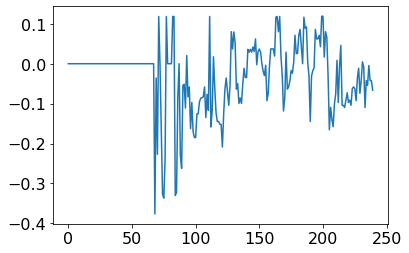

In [42]:
import matplotlib.pyplot as plt
x = pk.load(open("results/training_curves/LOCO_TransferCrabNet_Clf_run_0_fold_2.pk", "rb"))
plt.plot(range(len(x['classification'])), [y['MCC'] for y in x['classification']])

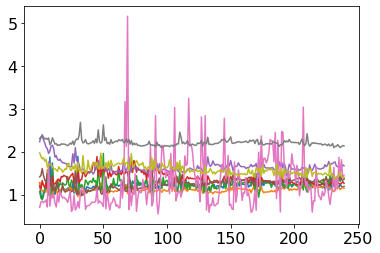

In [56]:
import matplotlib.pyplot as plt


for i in range(9):
    x = pk.load(open(f"results/training_curves/LOCO_TransferCrabNet_Reg_run_4_fold_{i}.pk", "rb"))
    plt.plot(range(len(x['target'])), [y['MAE'] for y in x['target']])